In [1]:
import os
os.chdir('../')

import warnings
warnings.filterwarnings('ignore')

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os

!nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"]="4"

Wed Jun 21 21:09:02 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.105.01   Driver Version: 515.105.01   CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A5000    Off  | 00000000:1B:00.0 Off |                    0 |
| 30%   31C    P2    56W / 230W |   1480MiB / 23028MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA RTX A5000    Off  | 00000000:1C:00.0 Off |                  Off |
| 30%   

### Hyperparams

In [3]:
n_mels = 8
n_outputs = 61
n_frames = 400
sr = 24000
fps = 30
train_csv_files = ['/Storage/speech/face/rvh_viseme2_1_iPhone_raw_30fps.csv',
                   '/Storage/speech/face/rvh_viseme2_2_iPhone_raw_30fps.csv',
                   '/Storage/speech/face/rvh_viseme2_3_iPhone_raw_30fps.csv',
                   '/Storage/speech/face/rvh_viseme2_4_iPhone_raw_30fps.csv',
                  ]
train_wav_files = ['/Storage/speech/face/rvh_viseme2_1_iPhone.wav',
                   '/Storage/speech/face/rvh_viseme2_2_iPhone.wav',
                   '/Storage/speech/face/rvh_viseme2_3_iPhone.wav',
                   '/Storage/speech/face/rvh_viseme2_4_iPhone.wav',
                  ]

test_csv_files = ['/Storage/speech/face/MySlate_6_박수철의_iPhone_30fps.csv']
test_wav_files = ['/Storage/speech/face/MySlate_6_박수철의_iPhone.wav']

### Model

In [4]:
from model.model_flow4 import Model
from utils.util import *
from tensorboardX import SummaryWriter

step = 0
device = 'cuda:0'

# Model
model = Model(in_dim=n_mels, out_dim=n_outputs)
model = model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
print('done')

done


### Load

In [5]:
save_dir = '/data/scpark/save/lips/train06.21-4/'
!mkdir -p $save_dir
!ls -lt $save_dir

writer = SummaryWriter(save_dir)

if False:
    step, model, _, optimizer = load(save_dir, 13000, model, None, optimizer)

total 4
-rw-rw-r-- 1 scpark scpark 40  6월 21 21:08 events.out.tfevents.1687349299.GPUSVR01


In [6]:
import torch
from data.dataset import LipsDataset, Collate

train_dataset = LipsDataset(train_wav_files, train_csv_files, n_frames, n_mels=n_mels, sr=sr, fps=fps, perturb=True)
print('train dataset :', len(train_dataset))
train_loader = torch.utils.data.DataLoader(train_dataset, num_workers=1, shuffle=True, batch_size=8, 
                                           collate_fn=Collate(n_frames, n_mels))
print(train_loader)

test_dataset = LipsDataset(test_wav_files, test_csv_files, n_frames, n_mels=n_mels, sr=sr, fps=fps, perturb=False)
print('test dataset :', len(test_dataset))
test_loader = torch.utils.data.DataLoader(test_dataset, num_workers=1, shuffle=True, batch_size=8,
                                           collate_fn=Collate(n_frames, n_mels))
print(test_loader)

train dataset : 28308
test dataset : 1413


test : 0 10.360796928405762
test : 1 10.750962257385254
test : 2 10.422483444213867
test : 3 10.53459358215332
test : 4 10.773906707763672
test : 5 10.73195743560791
test : 6 10.304821968078613
test : 7 10.8480863571167
test : 8 10.477371215820312
test : 9 10.822527885437012
test_loss : 10.602751731872559


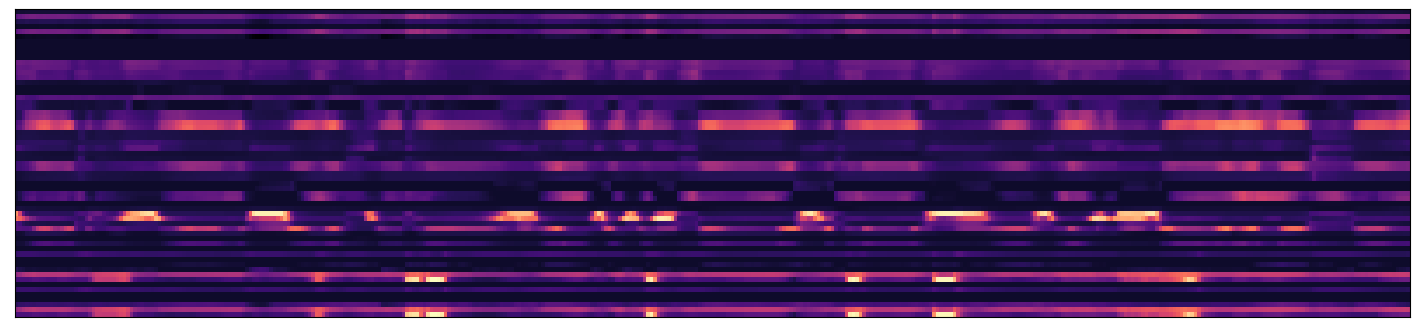

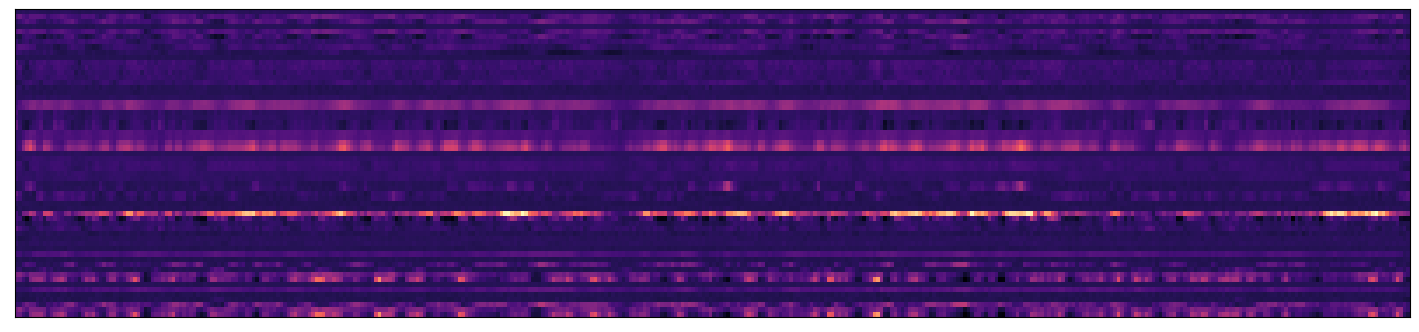

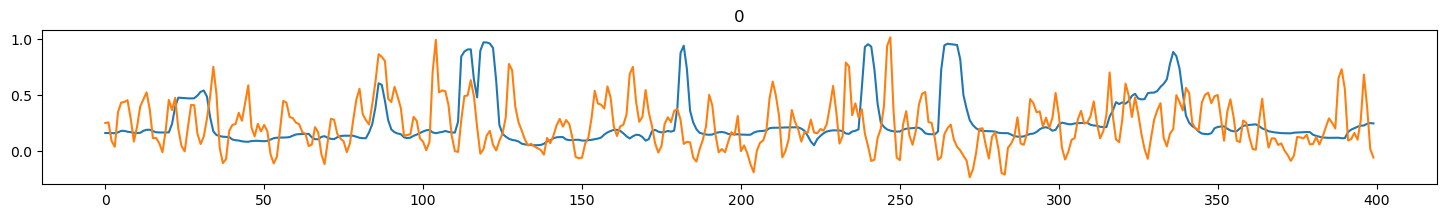

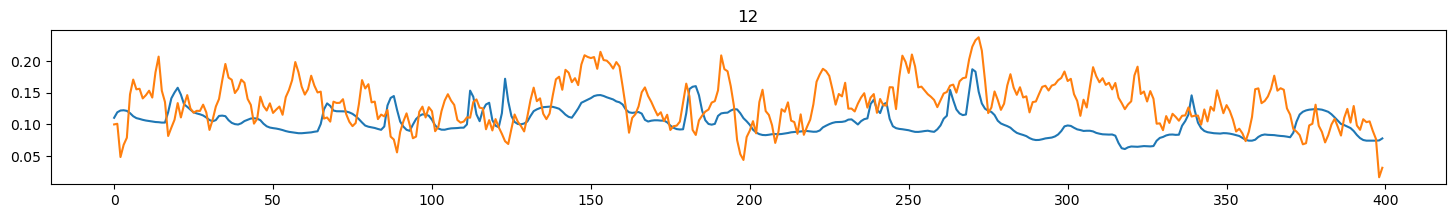

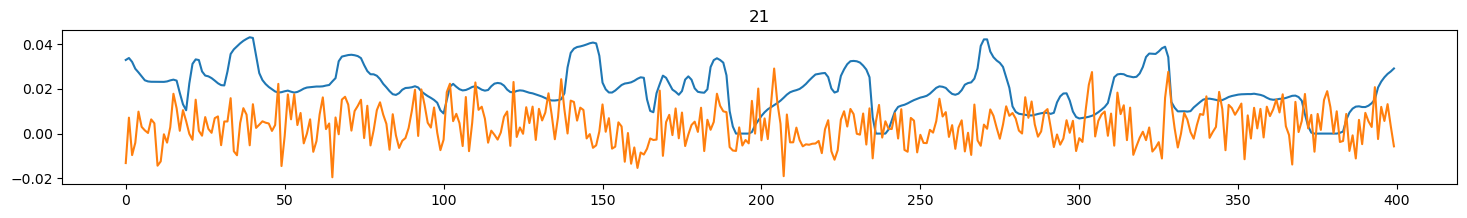

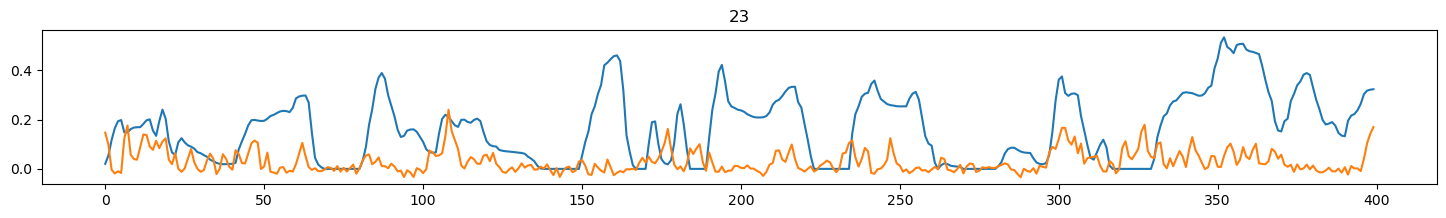

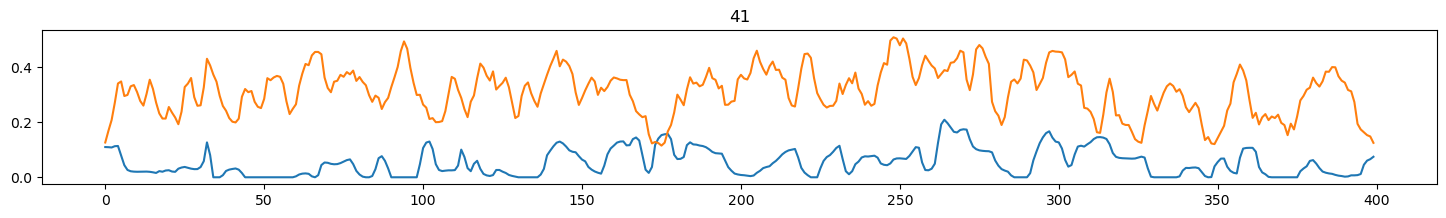

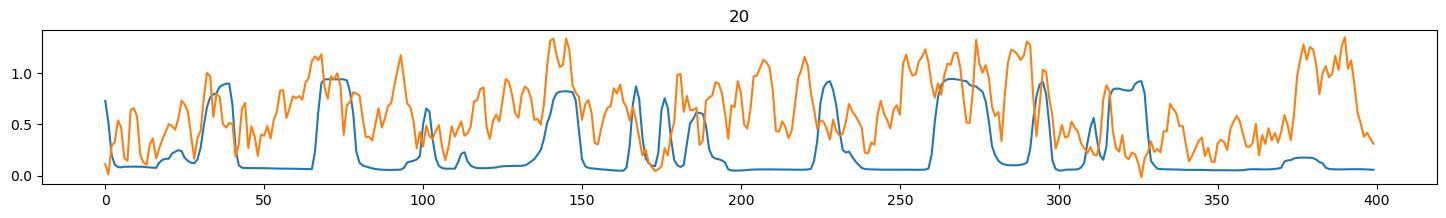

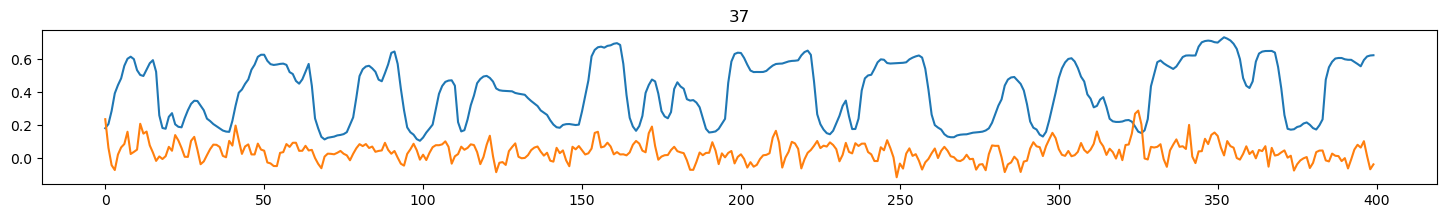

27901
27901 -3.343837261199951
27902
27902 -3.266437530517578
27903
27903 -3.3769092559814453
27904
27904 -3.3223204612731934
27905
27905 -3.3691744804382324
27906
27906 -3.446390390396118
27907
27907 -3.4780960083007812
27908
27908 -3.3893604278564453
27909
27909 -3.433370590209961
27910
27910 -3.5156965255737305
27911
27911 -3.359731674194336
27912
27912 -3.5327422618865967
27913
27913 -3.468846321105957
27914
27914 -3.4579997062683105
27915
27915 -3.5353336334228516
27916
27916 -3.5463740825653076
27917
27917 -3.49165415763855
27918
27918 -3.586294651031494
27919
27919 -3.481081485748291
27920
27920 -3.591254234313965
27921
27921 -3.4146804809570312
27922
27922 -3.498208999633789
27923
27923 -3.6416513919830322
27924
27924 -3.553445339202881
27925
27925 -3.5903091430664062
27926
27926 -3.5984740257263184
27927
27927 -3.565756320953369
27928
27928 -3.6532745361328125
27929
27929 -3.600924253463745
27930
27930 -3.588268280029297
27931
27931 -3.683310031890869
27932
27932 -3.6088616847

In [ ]:
from IPython import display
import librosa.display
import matplotlib.pyplot as plt

isnan = False
while True:
    if isnan:
        break
    for batch in train_loader:
        inputs = batch['inputs'].transpose(1, 2).to(device)
        targets = batch['outputs'].transpose(1, 2).to(device)
        
        model.train()
        model.zero_grad()
        outputs = model(inputs, targets)
        
        print(step)
        loss = outputs['total_loss']
        loss.backward()
        optimizer.step()
        print(step, loss.item())
        
        if step % 100 == 0:
            writer.add_scalar('train_loss', loss.item(), step)
        
        if step % 100 == 0:
            display.clear_output()
            
            losses = []
            for i, batch in enumerate(test_loader):
                if i >= 10:
                    break
                    
                inputs = batch['inputs'].transpose(1, 2).to(device)
                targets = batch['outputs'].transpose(1, 2).to(device)

                model.eval()
                with torch.no_grad():
                    outputs = model(inputs, targets)
                    
                loss = outputs['total_loss']
                print('test :', i, loss.item())
                losses.append(loss)        
            
            test_loss = torch.stack(losses).mean().item()
            print('test_loss :', test_loss)
            writer.add_scalar('test_loss', test_loss, step)
            
            with torch.no_grad():
                pred = model.inference(inputs)
            
            plt.figure(figsize=[18, 4])
            librosa.display.specshow(targets[0].data.cpu().numpy(), cmap='magma')
            plt.show()

            plt.figure(figsize=[18, 4])
            librosa.display.specshow(pred[0].data.cpu().numpy(), cmap='magma')
            plt.show()
            
            for i in [0, 12, 21, 23, 41]:
                plt.figure(figsize=[18, 2])
                plt.title(str(i))
                plt.plot(targets[0].data.cpu().numpy()[i])
                plt.plot(pred[0].data.cpu().numpy()[i])
                plt.show()
                
            for i in [20, 37]:
                plt.figure(figsize=[18, 2])
                plt.title(str(i))
                plt.plot(targets[0].data.cpu().numpy()[i])
                plt.plot(pred[0].data.cpu().numpy()[i])
                plt.show()

        if step % 1000 == 0:
            save(save_dir, step, model, None, optimizer)
    
        step += 1

In [8]:
save(save_dir, step, model, None, optimizer)

saved /data/scpark/save/lips/train06.21-4/save_27812
